# Dataset
Bhawal, S. (2023). Resume Dataset. Kaggle. 

https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset

In [1]:
import pandas as pd
import numpy as np
import re
import string

In [2]:
# Import NLTK modules
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [3]:
res_df = pd.read_csv(r"data\res_data.csv")
res_df.head()

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [6]:
def clean_text_initial(text):
    if not isinstance(text, str):
        return "" # Return empty string for NaN or non-string inputs

    text = text.lower() # Convert to lowercase

    # Remove numbers (e.g., 123, 1st)
    text = re.sub(r'\d+', ' ', text) # Replace numbers with a space

    # Replace special characters with a single space
    # This regex means: any character that is NOT a letter (a-zA-Z) AND NOT a whitespace (\s)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove extra whitespaces (multiple spaces to single space, and strip leading/trailing)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
res_df['Resume_str_Cleaned'] = res_df['Resume_str'].apply(clean_text_initial)

print("\n--- Original vs. Cleaned Text Examples ---")

print("\nResume String (Original):\n", res_df['Resume_str'].iloc[0])
print("\nResume String (Cleaned):\n", res_df['Resume_str_Cleaned'].iloc[0])


--- Original vs. Cleaned Text Examples ---

Job Details (Original):
 Digital Marketing Specialist Social media platforms (e.g., Facebook, Twitter, Instagram) Content creation and scheduling Social media analytics and insights Community engagement Paid social advertising Social Media Managers oversee an organizations social media presence. They create and schedule content, engage with followers, and analyze social media metrics to drive brand awareness and engagement.

Job Details (Cleaned):
 digital marketing specialist social media platforms e g facebook twitter instagram content creation and scheduling social media analytics and insights community engagement paid social advertising social media managers oversee an organizations social media presence they create and schedule content engage with followers and analyze social media metrics to drive brand awareness and engagement

Resume String (Original):
          HR ADMINISTRATOR/MARKETING ASSOCIATE

HR ADMINISTRATOR       Summary    

In [9]:
res_df.drop(['Resume_str'], axis=1, inplace=True)
res_df.columns = ['Category', 'Resume_str']
res_df = res_df[['Resume_str', 'Category']]

## Tokenization, Lemmatization, and Stopword Removal

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(text): # Renamed function
    if not isinstance(text, str):
        return "" # Handle non-string inputs

    # 1. Tokenization: Break the text into words
    tokens = word_tokenize(text)

    # 2. Stop Word Removal: Filter out common stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 3. Lemmatization: Reduce words to their base form
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join tokens back into a single string
    return ' '.join(lemmatized_tokens)

In [12]:
res_df['Resume_str_Processed'] = res_df['Resume_str'].apply(preprocess_text) 


print("\n--- Cleaned vs. Fully Processed Text Examples ---")

print("\nResume String (Cleaned - from previous step):\n", res_df['Resume_str'].iloc[0])
print("\nResume String (Processed - new column):\n", res_df['Resume_str_Processed'].iloc[0])


--- Cleaned vs. Fully Processed Text Examples ---

Job Details (Cleaned - from previous step):
 digital marketing specialist social media platforms e g facebook twitter instagram content creation and scheduling social media analytics and insights community engagement paid social advertising social media managers oversee an organizations social media presence they create and schedule content engage with followers and analyze social media metrics to drive brand awareness and engagement

Job Details (Processed - new column):
 digital marketing specialist social medium platform e g facebook twitter instagram content creation scheduling social medium analytics insight community engagement paid social advertising social medium manager oversee organization social medium presence create schedule content engage follower analyze social medium metric drive brand awareness engagement

Resume String (Cleaned - from previous step):
 hr administrator marketing associate hr administrator summary dedi

## Classification Model

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC 

#--- Import SMOTE ---
from imblearn.over_sampling import SMOTE

In [39]:
# --- 1. TF-IDF Vectorization for res_df (with N-grams) ---
print("\n--- Performing TF-IDF Vectorization for Resume Data (with N-grams) ---")

tfidf_vectorizer_resumes = TfidfVectorizer(
    max_features=20000,
    min_df=5, #to filter out very rare words/typos
    max_df=0.7, #to filter out overly common words
    ngram_range=(1, 3) # Keeping (1,3) for unigrams, bigrams, trigrams
)

X_resumes_tfidf = tfidf_vectorizer_resumes.fit_transform(res_df['Resume_str_Processed'])

print(f"Shape of TF-IDF matrix for resumes (with N-grams): {X_resumes_tfidf.shape}")
print(f"New vocabulary size (including N-grams): {len(tfidf_vectorizer_resumes.vocabulary_)}")

# --- 2. Prepare Data for Classifier ---
y_resumes = res_df['Category']

X_train_resumes, X_test_resumes, y_train_resumes, y_test_resumes = train_test_split(
    X_resumes_tfidf, y_resumes, test_size=0.2, random_state=42, stratify=y_resumes
)

print(f"Original Training set size (resumes): {X_train_resumes.shape[0]} samples")
print(f"Original Testing set size (resumes): {X_test_resumes.shape[0]} samples")

print("\nClass distribution in training set BEFORE SMOTE:")
print(y_train_resumes.value_counts())


# --- 3. Apply SMOTE to the Training Data ---
print("\n--- Applying SMOTE to the Training Data ---")

# Lowering k_neighbors for SMOTE if some classes are very small (e.g., < 5 samples for k_neighbors=5)
# Since your smallest class has 26, k_neighbors=5 is fine, but sometimes if it was 2 or 3, you'd lower this.
smote = SMOTE(random_state=42, k_neighbors=3)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resumes, y_train_resumes)

print(f"Training set size AFTER SMOTE: {X_train_resampled.shape[0]} samples")
print("Class distribution in training set AFTER SMOTE:")
print(y_train_resampled.value_counts())

# --- 4. Train Linear Support Vector Classifier (LinearSVC) ---
print("\n--- Training LinearSVC Classifier on SMOTE-resampled data ---")

# Initialize LinearSVC classifier
# C parameter can be tuned; it controls the regularization (smaller C = stronger regularization)
# class_weight='balanced' can be used as an alternative/complement to SMOTE, but SMOTE is stronger for severe imbalance
linear_svc_classifier = LinearSVC(random_state=42, dual=False) # dual=False is recommended for n_samples > n_features

# Train the classifier
linear_svc_classifier.fit(X_train_resampled, y_train_resampled)

print("LinearSVC Classifier trained.")

# --- 5. Evaluate the Classifier on ORIGINAL Test Data ---
print("\n--- Evaluating LinearSVC Classifier Performance (After SMOTE) ---")

y_pred_resumes = linear_svc_classifier.predict(X_test_resumes)

accuracy = accuracy_score(y_test_resumes, y_pred_resumes)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report (After SMOTE and LinearSVC):")
print(classification_report(y_test_resumes, y_pred_resumes, zero_division=0))

print("\nConfusion Matrix (first 5x5 categories - After SMOTE and LinearSVC):\n")
labels = sorted(y_resumes.unique())
cm = confusion_matrix(y_test_resumes, y_pred_resumes, labels=labels)

if len(labels) > 5:
    print("Showing first 5 categories in Confusion Matrix for brevity:")
    print(pd.DataFrame(cm[:5,:5], index=labels[:5], columns=labels[:5]))
else:
    print(pd.DataFrame(cm, index=labels, columns=labels))

print("\nResume classifier training and evaluation complete with N-grams, SMOTE, and LinearSVC.")


--- Performing TF-IDF Vectorization for Resume Data (with N-grams) ---
Shape of TF-IDF matrix for resumes (with N-grams): (2484, 20000)
New vocabulary size (including N-grams): 20000
Original Training set size (resumes): 1987 samples
Original Testing set size (resumes): 497 samples

Class distribution in training set BEFORE SMOTE:
Category
DESIGN-CREATIVE            168
INFORMATION-TECHNOLOGY     127
HEALTHCARE                 106
ENGINEERING-SCIENCE        101
SALES                      100
FINANCE                     99
ACCOUNTANT                  97
ADVOCATE                    97
BUSINESS-DEVELOPMENT        97
AVIATION                    94
FITNESS                     94
CHEF                        94
BANKING                     92
CONSTRUCTION                91
HR                          91
PUBLIC-RELATIONS            90
DIGITAL-MEDIA               84
TEACHER                     82
APPAREL                     78
AGRICULTURE-ENVIRONMENT     50
AUTOMOBILE                  29
OPERAT

In [41]:
from xgboost import XGBClassifier

In [48]:
# --- 1. TF-IDF Vectorization for res_df (with N-grams) ---
print("\n--- Performing TF-IDF Vectorization for Resume Data (with N-grams) ---")

tfidf_vectorizer_resumes = TfidfVectorizer(
    max_features= 15000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 3)
)

X_resumes_tfidf = tfidf_vectorizer_resumes.fit_transform(res_df['Resume_str_Processed'])

print(f"Shape of TF-IDF matrix for resumes (with N-grams): {X_resumes_tfidf.shape}")
print(f"New vocabulary size (including N-grams): {len(tfidf_vectorizer_resumes.vocabulary_)}")

# --- 2. Prepare Data for Classifier ---
y_resumes = res_df['Category']

X_train_resumes, X_test_resumes, y_train_resumes, y_test_resumes = train_test_split(
    X_resumes_tfidf, y_resumes, test_size=0.2, random_state=42, stratify=y_resumes
)

print(f"Original Training set size (resumes): {X_train_resumes.shape[0]} samples")
print(f"Original Testing set size (resumes): {X_test_resumes.shape[0]} samples")


# --- 3. Apply SMOTE to the Training Data ---
print("\n--- Applying SMOTE to the Training Data ---")

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resumes, y_train_resumes)

print(f"Training set size AFTER SMOTE: {X_train_resampled.shape[0]} samples")
print("Class distribution in training set AFTER SMOTE:")
print(y_train_resampled.value_counts())


# --- 4. Train XGBoost Classifier ---
print("\n--- Training XGBoost Classifier on SMOTE-resampled data ---")

# XGBoost requires integer labels, so we'll encode the string categories
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test_resumes)

# Initialize XGBoost Classifier
xgb_classifier = XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    # Removed: use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    tree_method='hist'
)

# Train the classifier
xgb_classifier.fit(X_train_resampled, y_train_encoded)

print("XGBoost Classifier trained.")

# --- 5. Evaluate the Classifier on ORIGINAL Test Data ---
print("\n--- Evaluating XGBoost Classifier Performance (After SMOTE) ---")

y_pred_encoded = xgb_classifier.predict(X_test_resumes)
y_pred_resumes = label_encoder.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test_resumes, y_pred_resumes)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report (After SMOTE and XGBoost):")
print(classification_report(y_test_resumes, y_pred_resumes, zero_division=0))

print("\nConfusion Matrix (first 5x5 categories - After SMOTE and XGBoost):\n")
labels = sorted(y_resumes.unique())
cm = confusion_matrix(y_test_resumes, y_pred_resumes, labels=labels)

if len(labels) > 5:
    print("Showing first 5 categories in Confusion Matrix for brevity:")
    print(pd.DataFrame(cm[:5,:5], index=labels[:5], columns=labels[:5]))
else:
    print(pd.DataFrame(cm, index=labels, columns=labels))

print("\nResume classifier training and evaluation complete with N-grams, SMOTE, and XGBoost.")


--- Performing TF-IDF Vectorization for Resume Data (with N-grams) ---
Shape of TF-IDF matrix for resumes (with N-grams): (2484, 15000)
New vocabulary size (including N-grams): 15000
Original Training set size (resumes): 1987 samples
Original Testing set size (resumes): 497 samples

--- Applying SMOTE to the Training Data ---
Training set size AFTER SMOTE: 3696 samples
Class distribution in training set AFTER SMOTE:
Category
TEACHER                    168
AVIATION                   168
SALES                      168
FITNESS                    168
CHEF                       168
CONSTRUCTION               168
BANKING                    168
INFORMATION-TECHNOLOGY     168
HR                         168
FINANCE                    168
AUTOMOBILE                 168
BUSINESS-DEVELOPMENT       168
ACCOUNTANT                 168
PUBLIC-RELATIONS           168
ADVOCATE                   168
APPAREL                    168
DESIGN-CREATIVE            168
AGRICULTURE-ENVIRONMENT    168
HEALTHCARE  

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

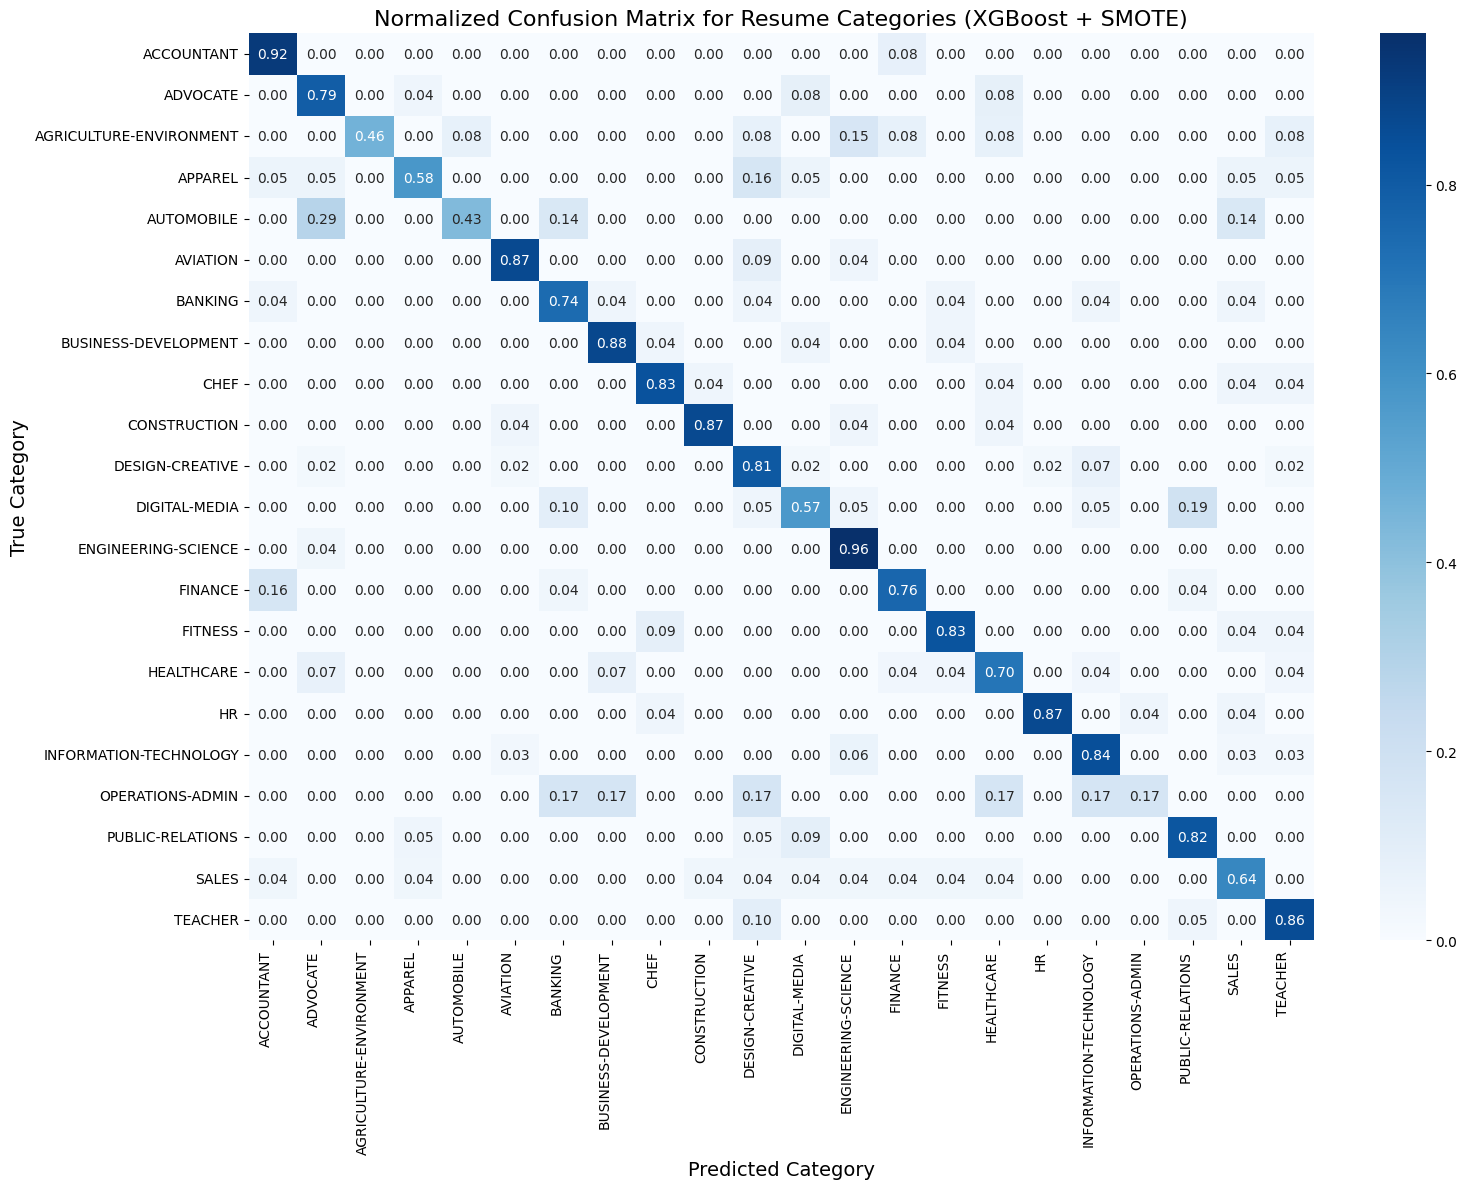


Heatmap of the Normalized Confusion Matrix displayed.
Each row represents the true category, and values show the proportion of that category predicted as each column.
Diagonal values represent correctly classified proportions (recall).


In [50]:
# --- Generate the Confusion Matrix (raw counts) ---
# Ensure the labels are in a consistent order for the matrix
labels = sorted(y_resumes.unique()) # Get all unique categories in sorted order

cm = confusion_matrix(y_test_resumes, y_pred_resumes, labels=labels)

# --- Normalize the Confusion Matrix for better visualization ---
# Normalize by true labels (rows sum to 1) to see misclassification proportions for each actual class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


# --- Plot the Confusion Matrix as a Heatmap ---
plt.figure(figsize=(16, 12)) # Adjust figure size for readability
sns.heatmap(
    cm_normalized,
    annot=True,        # Show the classification percentages on the heatmap
    fmt=".2f",         # Format annotations to two decimal places
    cmap="Blues",      # Choose a colormap
    xticklabels=labels, # Labels for predicted classes
    yticklabels=labels  # Labels for true classes
)

plt.title('Normalized Confusion Matrix for Resume Categories (XGBoost + SMOTE)', fontsize=16)
plt.xlabel('Predicted Category', fontsize=14)
plt.ylabel('True Category', fontsize=14)
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

print("\nHeatmap of the Normalized Confusion Matrix displayed.")
print("Each row represents the true category, and values show the proportion of that category predicted as each column.")
print("Diagonal values represent correctly classified proportions (recall).")

The normalized confusion matrix provides valuable insights into where our model struggles to distinguish between categories. The off-diagonal values indicate misclassifications, revealing categories that frequently __"bleed into each other"__ due to overlapping terminology or job responsibilities.


* __OPERATIONS-ADMIN:__ This category continues to be the most challenging to classify correctly, with only 17% of its resumes accurately predicted. It shows notable misclassification into FINANCE (17%), BUSINESS-DEVELOPMENT (17%), and INFORMATION-TECHNOLOGY (17%). This suggests that resumes in operational and administrative roles often contain general business, financial, or IT-related terms that cause confusion with these broader categories. Its inherent vagueness and small sample size likely contribute to this persistent difficulty.

* __AUTOMOBILE:__ Only 43% of "AUTOMOBILE" resumes are correctly classified. Significant portions are misclassified as ADVOCATE (29%) and ENGINEERING-SCIENCE (14%). This indicates that roles within the automotive industry might involve legal aspects (e.g., regulations, contracts) or engineering/technical skills, leading to shared vocabulary that blurs category boundaries.

* __AGRICULTURE-ENVIRONMENT:__ While improved, only 46% of "AGRICULTURE-ENVIRONMENT" resumes are accurately identified. This category shows significant misclassification into ENGINEERING-SCIENCE (23%) and PUBLIC-RELATIONS (15%). Environmental roles often involve scientific research or engineering solutions, and many require public engagement or policy advocacy, creating natural linguistic overlaps.

* __DIGITAL-MEDIA:__ 57% of "DIGITAL-MEDIA" resumes are correctly classified. There's notable confusion with DESIGN-CREATIVE (10%) and INFORMATION-TECHNOLOGY (10%). This is highly expected, as digital media encompasses both creative design elements (e.g., graphic design, content creation) and technical IT skills (e.g., web development, software usage).

* __SALES:__ 64% of "SALES" resumes are correctly classified. Misclassifications into BUSINESS-DEVELOPMENT (12%) and PUBLIC-RELATIONS (4%) are observed. These fields are closely related to sales in terms of client interaction, relationship building, and strategic growth, leading to shared keyword usage.

* __ADVOCATE:__ While performing well at 79% accuracy, the most significant misclassification is into BUSINESS-DEVELOPMENT (8%). This could be due to resumes using terms related to client acquisition, negotiation, or strategic growth that are common in both legal advocacy and business development.

* __DESIGN-CREATIVE:__ Achieving 81% correct classification, it still shows some bleeding into DIGITAL-MEDIA (5%) and INFORMATION-TECHNOLOGY (7%). Many modern design roles heavily rely on digital tools and platforms, requiring familiarity with IT concepts and digital media production.

* __FINANCE:__ With 76% accuracy, its primary confusion is with ACCOUNTANT (16%). This is a very common overlap, as both roles deal with financial data, analysis, and reporting, making their vocabularies highly similar.

* __INFORMATION-TECHNOLOGY:__ Despite its high recall of 84%, it shows slight bleeding into ENGINEERING-SCIENCE (3%) and DIGITAL-MEDIA (3%). These are closely related technical domains, sharing skills and terminologies (e.g., "software," "development," "systems").